In [1]:
import os
import cv2
import math
#import pafy
import random
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

C:\Users\jaghos\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\jaghos\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\jaghos\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
print(tf.__version__)

2.2.0


### Set Numpy, Python and Tensorflow seeds to get consistent results.

In [3]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# Create a Matplotlib figure
plt.figure(figsize = (30, 30))

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

In [4]:
Drive = "C:"
datafolder =  Drive+"/1-GG/CAP4/EventDetection/Dataset/VDO"


In [5]:
datafolder

'C:/1-GG/CAP4/EventDetection/Dataset/VDO'

### Example

In [6]:
### Find sub-folders under datafolder where train vdo are stored

In [7]:
def listdirs(folder):
    return [d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))]

In [8]:
folderList = listdirs(datafolder)
print(folderList)

['Basketball', 'SoccerPenalty']


In [9]:
## Fltering out required folders(class) from folderList (Basketball ,CricketBowling ,SoccerPenalty  )

In [10]:
# checks for each index i whether the corresponding filter Boolean value is True
#filter_lst = [False ,True, True,False]
filter_lst = [True, True]
classes_list = [folderList[i] for i in range(len(folderList)) if filter_lst[i]]
print(classes_list)

['Basketball', 'SoccerPenalty']


In [11]:
### Testing class , number of vdo files under each class , full path name

In [12]:
for child in os.listdir(datafolder):
    if child in classes_list:   # Only consider that matches with "all_classes_names"
        pass
    else:
        continue

    print(child) # Name of the vdo folder
    
    baseimagefolders = os.path.join(datafolder, child)
    print(baseimagefolders)       # File with complete path 
    print(len(baseimagefolders))  # Number of files under each folders

Basketball
C:/1-GG/CAP4/EventDetection/Dataset/VDO\Basketball
50
SoccerPenalty
C:/1-GG/CAP4/EventDetection/Dataset/VDO\SoccerPenalty
53


#### C:\1-GG\CAP4\EventDetection\Dataset\VDO\SoccerPenalty

## End of example

In [13]:
image_height, image_width = 64, 64
max_images_per_class = 5000
model_output_size = len(classes_list)
print(model_output_size)

2


### Extract, Resize and Normalize Frames

In [14]:
def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []
    
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)

    # Iterating through Video Frames
    while True:

        # Reading a frame from the video file 
        success, frame = video_reader.read() 

        # If Video frame was not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # returning the frames list 
    return frames_list

## Explanation - two loops of function (create_dataset()) below

#### Basketball - class_name
### C:\1-GG\CAP4\EventDetection\Dataset\VDO\Basketball -  files_list
file_name = v_Basketball_g01_c01
### C:\1-GG\CAP4\EventDetection\Dataset\VDO\Basketball/ v_Basketball_g01_c01 - video_file_path


### C:\1-GG\CAP4\EventDetection\Dataset\VDO\Basketball/v_Basketball_g01_c02 - video_file_path

### Dataset Creation

In [15]:
def create_dataset():

    # Declaring Empty Lists to store the features and labels values.
    temp_features = [] 
    features = []
    labels = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
        
        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(datafolder, class_name))

        # Iterating through all the files present in the files list
        for file_name in files_list:

            # Construct the complete video path
            video_file_path = os.path.join(datafolder, class_name, file_name)

            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)

            # Appending the frames to a temporary list.
            temp_features.extend(frames)
        
        # Adding randomly selected frames to the features list
        features.extend(random.sample(temp_features, max_images_per_class))

        # Adding Fixed number of labels to the labels list
        labels.extend([class_index] * max_images_per_class)
        
        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()

    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels

### Calling the create_dataset method which returns features and labels.

In [16]:
features, labels = create_dataset()
print("Completed Extracting")


Extracting Data of Class: Basketball
Extracting Data of Class: SoccerPenalty
Completed Extracting


In [17]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

### Split data set

In [18]:
features_train, features_test, labels_train, labels_test =\
    train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = 28)

In [19]:
features_test

array([[[[0.87843137, 0.88235294, 0.81176471],
         [0.87843137, 0.88235294, 0.81176471],
         [0.9254902 , 0.92941176, 0.85882353],
         ...,
         [0.79215686, 0.85882353, 0.78823529],
         [0.7372549 , 0.80392157, 0.73333333],
         [0.7372549 , 0.80392157, 0.73333333]],

        [[0.87843137, 0.88235294, 0.81176471],
         [0.87843137, 0.88235294, 0.81176471],
         [0.9254902 , 0.92941176, 0.85882353],
         ...,
         [0.79215686, 0.85882353, 0.78823529],
         [0.7372549 , 0.80392157, 0.73333333],
         [0.7372549 , 0.80392157, 0.73333333]],

        [[0.89803922, 0.90196078, 0.83137255],
         [0.89803922, 0.90196078, 0.83137255],
         [0.91372549, 0.91764706, 0.84705882],
         ...,
         [0.82352941, 0.89019608, 0.81960784],
         [0.77254902, 0.83921569, 0.76862745],
         [0.77254902, 0.83921569, 0.76862745]],

        ...,

        [[0.27843137, 0.38823529, 0.40784314],
         [0.27843137, 0.38823529, 0.40784314]

In [20]:
features_train

array([[[[0.12156863, 0.12941176, 0.01568627],
         [0.14117647, 0.14509804, 0.03921569],
         [0.16862745, 0.18039216, 0.05490196],
         ...,
         [0.21960784, 0.16862745, 0.20392157],
         [0.2       , 0.17647059, 0.18823529],
         [0.60784314, 0.48235294, 0.45882353]],

        [[0.09803922, 0.09411765, 0.01568627],
         [0.08235294, 0.0627451 , 0.        ],
         [0.12941176, 0.11764706, 0.03921569],
         ...,
         [0.21568627, 0.1372549 , 0.14509804],
         [0.30588235, 0.30588235, 0.28627451],
         [0.42352941, 0.31372549, 0.31372549]],

        [[0.08627451, 0.07058824, 0.00784314],
         [0.05098039, 0.02352941, 0.        ],
         [0.05098039, 0.01960784, 0.01176471],
         ...,
         [0.27843137, 0.21176471, 0.20392157],
         [0.16078431, 0.14117647, 0.15294118],
         [0.22352941, 0.1372549 , 0.16470588]],

        ...,

        [[0.30196078, 0.57254902, 0.41568627],
         [0.30980392, 0.57647059, 0.41960784]

### Step 5: Construct the Model

In [21]:
# simple CNN Classification model with two CNN layers.
# Let's create a function that will construct our model
def create_model():

    # We will use a Sequential model for model construction
    model = Sequential()

    # Defining The Model Architecture
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
    model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(16, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))

    # Printing the models summary
    model.summary()

    return model


# Calling the create_model method
model = create_model()

print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 58, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 16)        4624      
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 56, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 16)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 16)                0

In [22]:
### For plot_model , following libraries required
##pip install pydot
##pip install pydotplus
## pip install graphviz

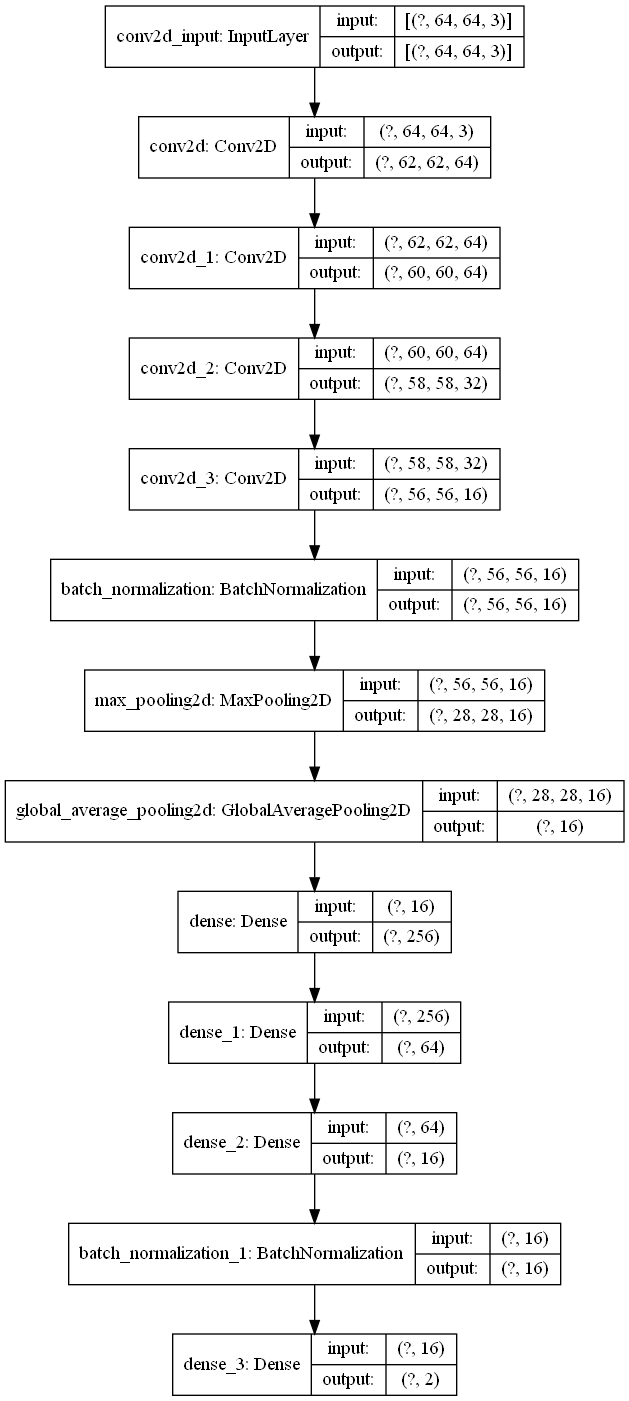

In [23]:
## Check Model architecture
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

### Step 6: Compile and Train the Model

In [24]:
%%time
# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start Training

model_training_history = model.fit(x = features_train, y = labels_train, epochs = 20, verbose= 1, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/20


 778/1600 [=============>................] - ETA: 0s - loss: 0.5974 - accuracy: 0.50 - ETA: 11s - loss: 0.6176 - accuracy: 0.642 - ETA: 13s - loss: 0.6066 - accuracy: 0.634 - ETA: 13s - loss: 0.5465 - accuracy: 0.684 - ETA: 13s - loss: 0.5181 - accuracy: 0.720 - ETA: 13s - loss: 0.5056 - accuracy: 0.733 - ETA: 14s - loss: 0.5246 - accuracy: 0.728 - ETA: 15s - loss: 0.5059 - accuracy: 0.743 - ETA: 15s - loss: 0.5152 - accuracy: 0.738 - ETA: 15s - loss: 0.5165 - accuracy: 0.745 - ETA: 15s - loss: 0.5135 - accuracy: 0.745 - ETA: 15s - loss: 0.5171 - accuracy: 0.745 - ETA: 15s - loss: 0.5222 - accuracy: 0.734 - ETA: 15s - loss: 0.5182 - accuracy: 0.739 - ETA: 14s - loss: 0.5088 - accuracy: 0.740 - ETA: 14s - loss: 0.5081 - accuracy: 0.741 - ETA: 14s - loss: 0.5334 - accuracy: 0.727 - ETA: 14s - loss: 0.5231 - accuracy: 0.734 - ETA: 15s - loss: 0.5152 - accuracy: 0.734 - ETA: 14s - loss: 0.5162 - accuracy: 0.733 - ETA: 15s - loss: 0.5134 - accuracy: 0.736 - ETA: 14s - loss: 0.5112 - accurac

1518/1600 [===========================>..] - ETA: 10s - loss: 0.4545 - accuracy: 0.794 - ETA: 10s - loss: 0.4554 - accuracy: 0.794 - ETA: 10s - loss: 0.4540 - accuracy: 0.795 - ETA: 10s - loss: 0.4553 - accuracy: 0.795 - ETA: 10s - loss: 0.4549 - accuracy: 0.795 - ETA: 10s - loss: 0.4544 - accuracy: 0.795 - ETA: 10s - loss: 0.4543 - accuracy: 0.795 - ETA: 10s - loss: 0.4543 - accuracy: 0.795 - ETA: 10s - loss: 0.4544 - accuracy: 0.795 - ETA: 10s - loss: 0.4541 - accuracy: 0.796 - ETA: 10s - loss: 0.4539 - accuracy: 0.796 - ETA: 10s - loss: 0.4519 - accuracy: 0.797 - ETA: 10s - loss: 0.4510 - accuracy: 0.798 - ETA: 10s - loss: 0.4513 - accuracy: 0.797 - ETA: 10s - loss: 0.4495 - accuracy: 0.798 - ETA: 10s - loss: 0.4481 - accuracy: 0.799 - ETA: 10s - loss: 0.4473 - accuracy: 0.800 - ETA: 9s - loss: 0.4483 - accuracy: 0.799 - ETA: 9s - loss: 0.4497 - accuracy: 0.79 - ETA: 9s - loss: 0.4508 - accuracy: 0.79 - ETA: 9s - loss: 0.4531 - accuracy: 0.79 - ETA: 9s - loss: 0.4536 - accuracy: 0.7

1600/1600 [==============================] - ETA: 1s - loss: 0.4228 - accuracy: 0.81 - ETA: 1s - loss: 0.4224 - accuracy: 0.81 - ETA: 1s - loss: 0.4215 - accuracy: 0.81 - ETA: 1s - loss: 0.4211 - accuracy: 0.81 - ETA: 0s - loss: 0.4209 - accuracy: 0.81 - ETA: 0s - loss: 0.4212 - accuracy: 0.81 - ETA: 0s - loss: 0.4209 - accuracy: 0.81 - ETA: 0s - loss: 0.4205 - accuracy: 0.81 - ETA: 0s - loss: 0.4202 - accuracy: 0.81 - ETA: 0s - loss: 0.4196 - accuracy: 0.81 - ETA: 0s - loss: 0.4192 - accuracy: 0.81 - ETA: 0s - loss: 0.4189 - accuracy: 0.81 - ETA: 0s - loss: 0.4196 - accuracy: 0.81 - ETA: 0s - loss: 0.4200 - accuracy: 0.81 - ETA: 0s - loss: 0.4196 - accuracy: 0.81 - ETA: 0s - loss: 0.4190 - accuracy: 0.81 - ETA: 0s - loss: 0.4187 - accuracy: 0.81 - ETA: 0s - loss: 0.4187 - accuracy: 0.81 - ETA: 0s - loss: 0.4182 - accuracy: 0.81 - ETA: 0s - loss: 0.4187 - accuracy: 0.81 - ETA: 0s - loss: 0.4181 - accuracy: 0.81 - ETA: 0s - loss: 0.4186 - accuracy: 0.81 - ETA: 0s - loss: 0.4183 - accura

 653/1600 [===========>..................] - ETA: 0s - loss: 0.0645 - accuracy: 1.00 - ETA: 16s - loss: 0.1444 - accuracy: 0.950 - ETA: 21s - loss: 0.2198 - accuracy: 0.906 - ETA: 22s - loss: 0.2764 - accuracy: 0.875 - ETA: 22s - loss: 0.2712 - accuracy: 0.890 - ETA: 22s - loss: 0.3177 - accuracy: 0.868 - ETA: 22s - loss: 0.3361 - accuracy: 0.858 - ETA: 23s - loss: 0.3311 - accuracy: 0.865 - ETA: 24s - loss: 0.3249 - accuracy: 0.853 - ETA: 25s - loss: 0.3172 - accuracy: 0.862 - ETA: 25s - loss: 0.3224 - accuracy: 0.852 - ETA: 25s - loss: 0.3191 - accuracy: 0.851 - ETA: 25s - loss: 0.3446 - accuracy: 0.847 - ETA: 25s - loss: 0.3367 - accuracy: 0.852 - ETA: 25s - loss: 0.3361 - accuracy: 0.851 - ETA: 24s - loss: 0.3268 - accuracy: 0.855 - ETA: 24s - loss: 0.3139 - accuracy: 0.861 - ETA: 24s - loss: 0.3215 - accuracy: 0.862 - ETA: 24s - loss: 0.3162 - accuracy: 0.865 - ETA: 24s - loss: 0.3208 - accuracy: 0.863 - ETA: 25s - loss: 0.3229 - accuracy: 0.860 - ETA: 25s - loss: 0.3259 - accurac

1485/1600 [==========================>...] - ETA: 15s - loss: 0.3810 - accuracy: 0.840 - ETA: 15s - loss: 0.3805 - accuracy: 0.840 - ETA: 15s - loss: 0.3822 - accuracy: 0.839 - ETA: 15s - loss: 0.3812 - accuracy: 0.840 - ETA: 15s - loss: 0.3828 - accuracy: 0.840 - ETA: 15s - loss: 0.3852 - accuracy: 0.838 - ETA: 15s - loss: 0.3843 - accuracy: 0.839 - ETA: 15s - loss: 0.3838 - accuracy: 0.840 - ETA: 15s - loss: 0.3835 - accuracy: 0.840 - ETA: 15s - loss: 0.3829 - accuracy: 0.840 - ETA: 15s - loss: 0.3846 - accuracy: 0.840 - ETA: 15s - loss: 0.3830 - accuracy: 0.841 - ETA: 14s - loss: 0.3832 - accuracy: 0.840 - ETA: 14s - loss: 0.3830 - accuracy: 0.840 - ETA: 14s - loss: 0.3831 - accuracy: 0.840 - ETA: 14s - loss: 0.3823 - accuracy: 0.840 - ETA: 14s - loss: 0.3830 - accuracy: 0.839 - ETA: 14s - loss: 0.3844 - accuracy: 0.839 - ETA: 14s - loss: 0.3843 - accuracy: 0.839 - ETA: 14s - loss: 0.3834 - accuracy: 0.839 - ETA: 14s - loss: 0.3838 - accuracy: 0.839 - ETA: 14s - loss: 0.3850 - accur

1600/1600 [==============================] - ETA: 1s - loss: 0.3784 - accuracy: 0.84 - ETA: 1s - loss: 0.3781 - accuracy: 0.84 - ETA: 1s - loss: 0.3789 - accuracy: 0.84 - ETA: 1s - loss: 0.3791 - accuracy: 0.84 - ETA: 1s - loss: 0.3783 - accuracy: 0.84 - ETA: 1s - loss: 0.3782 - accuracy: 0.84 - ETA: 1s - loss: 0.3792 - accuracy: 0.84 - ETA: 0s - loss: 0.3798 - accuracy: 0.84 - ETA: 0s - loss: 0.3807 - accuracy: 0.84 - ETA: 0s - loss: 0.3803 - accuracy: 0.84 - ETA: 0s - loss: 0.3793 - accuracy: 0.84 - ETA: 0s - loss: 0.3785 - accuracy: 0.84 - ETA: 0s - loss: 0.3794 - accuracy: 0.84 - ETA: 0s - loss: 0.3803 - accuracy: 0.84 - ETA: 0s - loss: 0.3795 - accuracy: 0.84 - ETA: 0s - loss: 0.3795 - accuracy: 0.84 - ETA: 0s - loss: 0.3794 - accuracy: 0.84 - ETA: 0s - loss: 0.3802 - accuracy: 0.84 - 24s 15ms/step - loss: 0.3800 - accuracy: 0.8467 - val_loss: 0.2673 - val_accuracy: 0.9312
Epoch 3/20


 906/1600 [===============>..............] - ETA: 0s - loss: 0.2763 - accuracy: 1.00 - ETA: 10s - loss: 0.2518 - accuracy: 0.937 - ETA: 11s - loss: 0.3331 - accuracy: 0.900 - ETA: 11s - loss: 0.3295 - accuracy: 0.863 - ETA: 11s - loss: 0.3481 - accuracy: 0.850 - ETA: 11s - loss: 0.3762 - accuracy: 0.837 - ETA: 12s - loss: 0.3532 - accuracy: 0.854 - ETA: 12s - loss: 0.3529 - accuracy: 0.859 - ETA: 12s - loss: 0.3737 - accuracy: 0.842 - ETA: 12s - loss: 0.3699 - accuracy: 0.845 - ETA: 12s - loss: 0.3780 - accuracy: 0.832 - ETA: 12s - loss: 0.3755 - accuracy: 0.828 - ETA: 12s - loss: 0.3644 - accuracy: 0.838 - ETA: 12s - loss: 0.3659 - accuracy: 0.841 - ETA: 12s - loss: 0.3761 - accuracy: 0.829 - ETA: 12s - loss: 0.3748 - accuracy: 0.827 - ETA: 12s - loss: 0.3715 - accuracy: 0.831 - ETA: 12s - loss: 0.3629 - accuracy: 0.836 - ETA: 12s - loss: 0.3605 - accuracy: 0.835 - ETA: 12s - loss: 0.3702 - accuracy: 0.826 - ETA: 12s - loss: 0.3626 - accuracy: 0.832 - ETA: 11s - loss: 0.3543 - accurac

1600/1600 [==============================] - ETA: 7s - loss: 0.3376 - accuracy: 0.86 - ETA: 7s - loss: 0.3373 - accuracy: 0.86 - ETA: 7s - loss: 0.3369 - accuracy: 0.86 - ETA: 7s - loss: 0.3363 - accuracy: 0.86 - ETA: 7s - loss: 0.3357 - accuracy: 0.86 - ETA: 7s - loss: 0.3352 - accuracy: 0.86 - ETA: 7s - loss: 0.3351 - accuracy: 0.86 - ETA: 7s - loss: 0.3366 - accuracy: 0.86 - ETA: 7s - loss: 0.3361 - accuracy: 0.86 - ETA: 7s - loss: 0.3352 - accuracy: 0.86 - ETA: 7s - loss: 0.3353 - accuracy: 0.86 - ETA: 7s - loss: 0.3342 - accuracy: 0.86 - ETA: 7s - loss: 0.3338 - accuracy: 0.86 - ETA: 7s - loss: 0.3334 - accuracy: 0.86 - ETA: 7s - loss: 0.3338 - accuracy: 0.86 - ETA: 7s - loss: 0.3333 - accuracy: 0.86 - ETA: 7s - loss: 0.3328 - accuracy: 0.86 - ETA: 7s - loss: 0.3326 - accuracy: 0.86 - ETA: 7s - loss: 0.3326 - accuracy: 0.86 - ETA: 7s - loss: 0.3311 - accuracy: 0.86 - ETA: 7s - loss: 0.3309 - accuracy: 0.86 - ETA: 6s - loss: 0.3301 - accuracy: 0.87 - ETA: 6s - loss: 0.3305 - accura

 579/1600 [=========>....................] - ETA: 0s - loss: 0.0984 - accuracy: 1.00 - ETA: 11s - loss: 0.2473 - accuracy: 0.892 - ETA: 12s - loss: 0.3428 - accuracy: 0.884 - ETA: 13s - loss: 0.3549 - accuracy: 0.868 - ETA: 14s - loss: 0.3628 - accuracy: 0.875 - ETA: 15s - loss: 0.3485 - accuracy: 0.879 - ETA: 16s - loss: 0.3443 - accuracy: 0.879 - ETA: 16s - loss: 0.3608 - accuracy: 0.875 - ETA: 16s - loss: 0.3641 - accuracy: 0.865 - ETA: 16s - loss: 0.3455 - accuracy: 0.869 - ETA: 18s - loss: 0.3391 - accuracy: 0.872 - ETA: 18s - loss: 0.3385 - accuracy: 0.870 - ETA: 19s - loss: 0.3476 - accuracy: 0.863 - ETA: 18s - loss: 0.3537 - accuracy: 0.862 - ETA: 18s - loss: 0.3600 - accuracy: 0.855 - ETA: 17s - loss: 0.3507 - accuracy: 0.864 - ETA: 17s - loss: 0.3560 - accuracy: 0.858 - ETA: 17s - loss: 0.3649 - accuracy: 0.850 - ETA: 17s - loss: 0.3638 - accuracy: 0.852 - ETA: 17s - loss: 0.3540 - accuracy: 0.859 - ETA: 17s - loss: 0.3518 - accuracy: 0.858 - ETA: 17s - loss: 0.3410 - accurac

1184/1600 [=====================>........] - ETA: 25s - loss: 0.3032 - accuracy: 0.876 - ETA: 25s - loss: 0.3038 - accuracy: 0.876 - ETA: 25s - loss: 0.3053 - accuracy: 0.875 - ETA: 25s - loss: 0.3058 - accuracy: 0.875 - ETA: 24s - loss: 0.3060 - accuracy: 0.874 - ETA: 24s - loss: 0.3067 - accuracy: 0.875 - ETA: 24s - loss: 0.3054 - accuracy: 0.875 - ETA: 24s - loss: 0.3054 - accuracy: 0.875 - ETA: 23s - loss: 0.3051 - accuracy: 0.875 - ETA: 23s - loss: 0.3084 - accuracy: 0.874 - ETA: 23s - loss: 0.3074 - accuracy: 0.874 - ETA: 23s - loss: 0.3103 - accuracy: 0.874 - ETA: 23s - loss: 0.3103 - accuracy: 0.874 - ETA: 23s - loss: 0.3098 - accuracy: 0.874 - ETA: 23s - loss: 0.3106 - accuracy: 0.873 - ETA: 23s - loss: 0.3098 - accuracy: 0.874 - ETA: 23s - loss: 0.3101 - accuracy: 0.874 - ETA: 22s - loss: 0.3104 - accuracy: 0.873 - ETA: 22s - loss: 0.3092 - accuracy: 0.874 - ETA: 22s - loss: 0.3084 - accuracy: 0.875 - ETA: 22s - loss: 0.3080 - accuracy: 0.875 - ETA: 22s - loss: 0.3073 - accur

1600/1600 [==============================] - ETA: 10s - loss: 0.3017 - accuracy: 0.882 - ETA: 10s - loss: 0.3020 - accuracy: 0.882 - ETA: 10s - loss: 0.3021 - accuracy: 0.882 - ETA: 10s - loss: 0.3020 - accuracy: 0.882 - ETA: 10s - loss: 0.3014 - accuracy: 0.882 - ETA: 10s - loss: 0.3020 - accuracy: 0.882 - ETA: 9s - loss: 0.3017 - accuracy: 0.882 - ETA: 9s - loss: 0.3016 - accuracy: 0.88 - ETA: 9s - loss: 0.3018 - accuracy: 0.88 - ETA: 9s - loss: 0.3024 - accuracy: 0.88 - ETA: 9s - loss: 0.3025 - accuracy: 0.88 - ETA: 9s - loss: 0.3026 - accuracy: 0.88 - ETA: 9s - loss: 0.3024 - accuracy: 0.88 - ETA: 9s - loss: 0.3026 - accuracy: 0.88 - ETA: 9s - loss: 0.3023 - accuracy: 0.88 - ETA: 9s - loss: 0.3025 - accuracy: 0.88 - ETA: 9s - loss: 0.3022 - accuracy: 0.88 - ETA: 9s - loss: 0.3023 - accuracy: 0.87 - ETA: 8s - loss: 0.3032 - accuracy: 0.87 - ETA: 8s - loss: 0.3030 - accuracy: 0.87 - ETA: 8s - loss: 0.3031 - accuracy: 0.87 - ETA: 8s - loss: 0.3029 - accuracy: 0.87 - ETA: 8s - loss: 0.

 586/1600 [=========>....................] - ETA: 0s - loss: 0.1233 - accuracy: 1.00 - ETA: 18s - loss: 0.2327 - accuracy: 0.900 - ETA: 17s - loss: 0.2987 - accuracy: 0.875 - ETA: 17s - loss: 0.2794 - accuracy: 0.883 - ETA: 17s - loss: 0.2904 - accuracy: 0.900 - ETA: 19s - loss: 0.3035 - accuracy: 0.902 - ETA: 19s - loss: 0.2987 - accuracy: 0.898 - ETA: 19s - loss: 0.2873 - accuracy: 0.898 - ETA: 19s - loss: 0.3022 - accuracy: 0.892 - ETA: 19s - loss: 0.2915 - accuracy: 0.887 - ETA: 19s - loss: 0.2888 - accuracy: 0.888 - ETA: 18s - loss: 0.2855 - accuracy: 0.887 - ETA: 18s - loss: 0.3009 - accuracy: 0.875 - ETA: 18s - loss: 0.3168 - accuracy: 0.877 - ETA: 18s - loss: 0.3292 - accuracy: 0.875 - ETA: 18s - loss: 0.3321 - accuracy: 0.873 - ETA: 18s - loss: 0.3317 - accuracy: 0.875 - ETA: 17s - loss: 0.3353 - accuracy: 0.870 - ETA: 17s - loss: 0.3402 - accuracy: 0.864 - ETA: 17s - loss: 0.3364 - accuracy: 0.869 - ETA: 17s - loss: 0.3321 - accuracy: 0.871 - ETA: 17s - loss: 0.3184 - accurac

1327/1600 [=======================>......] - ETA: 21s - loss: 0.2901 - accuracy: 0.884 - ETA: 21s - loss: 0.2893 - accuracy: 0.884 - ETA: 21s - loss: 0.2887 - accuracy: 0.884 - ETA: 21s - loss: 0.2888 - accuracy: 0.884 - ETA: 21s - loss: 0.2915 - accuracy: 0.883 - ETA: 21s - loss: 0.2909 - accuracy: 0.883 - ETA: 21s - loss: 0.2907 - accuracy: 0.883 - ETA: 21s - loss: 0.2911 - accuracy: 0.883 - ETA: 21s - loss: 0.2900 - accuracy: 0.884 - ETA: 21s - loss: 0.2893 - accuracy: 0.884 - ETA: 21s - loss: 0.2895 - accuracy: 0.884 - ETA: 20s - loss: 0.2882 - accuracy: 0.885 - ETA: 20s - loss: 0.2874 - accuracy: 0.885 - ETA: 20s - loss: 0.2876 - accuracy: 0.885 - ETA: 20s - loss: 0.2873 - accuracy: 0.885 - ETA: 20s - loss: 0.2889 - accuracy: 0.884 - ETA: 20s - loss: 0.2908 - accuracy: 0.883 - ETA: 20s - loss: 0.2897 - accuracy: 0.884 - ETA: 20s - loss: 0.2886 - accuracy: 0.885 - ETA: 19s - loss: 0.2876 - accuracy: 0.885 - ETA: 19s - loss: 0.2876 - accuracy: 0.885 - ETA: 19s - loss: 0.2874 - accur

1600/1600 [==============================] - ETA: 4s - loss: 0.2881 - accuracy: 0.89 - ETA: 4s - loss: 0.2879 - accuracy: 0.89 - ETA: 4s - loss: 0.2880 - accuracy: 0.89 - ETA: 4s - loss: 0.2883 - accuracy: 0.89 - ETA: 4s - loss: 0.2886 - accuracy: 0.89 - ETA: 4s - loss: 0.2883 - accuracy: 0.89 - ETA: 3s - loss: 0.2882 - accuracy: 0.89 - ETA: 3s - loss: 0.2877 - accuracy: 0.89 - ETA: 3s - loss: 0.2877 - accuracy: 0.89 - ETA: 3s - loss: 0.2876 - accuracy: 0.89 - ETA: 3s - loss: 0.2882 - accuracy: 0.89 - ETA: 3s - loss: 0.2878 - accuracy: 0.89 - ETA: 3s - loss: 0.2875 - accuracy: 0.89 - ETA: 3s - loss: 0.2872 - accuracy: 0.89 - ETA: 3s - loss: 0.2874 - accuracy: 0.89 - ETA: 3s - loss: 0.2874 - accuracy: 0.89 - ETA: 2s - loss: 0.2876 - accuracy: 0.89 - ETA: 2s - loss: 0.2884 - accuracy: 0.89 - ETA: 2s - loss: 0.2875 - accuracy: 0.89 - ETA: 2s - loss: 0.2871 - accuracy: 0.89 - ETA: 2s - loss: 0.2872 - accuracy: 0.89 - ETA: 2s - loss: 0.2872 - accuracy: 0.89 - ETA: 2s - loss: 0.2874 - accura

1091/1600 [===================>..........] - ETA: 0s - loss: 0.0244 - accuracy: 1.00 - ETA: 10s - loss: 0.2660 - accuracy: 0.812 - ETA: 12s - loss: 0.3013 - accuracy: 0.839 - ETA: 12s - loss: 0.3136 - accuracy: 0.857 - ETA: 12s - loss: 0.3694 - accuracy: 0.812 - ETA: 12s - loss: 0.3643 - accuracy: 0.833 - ETA: 12s - loss: 0.3766 - accuracy: 0.812 - ETA: 12s - loss: 0.3839 - accuracy: 0.820 - ETA: 12s - loss: 0.4004 - accuracy: 0.830 - ETA: 12s - loss: 0.3784 - accuracy: 0.841 - ETA: 12s - loss: 0.3856 - accuracy: 0.835 - ETA: 12s - loss: 0.3758 - accuracy: 0.837 - ETA: 12s - loss: 0.3777 - accuracy: 0.827 - ETA: 12s - loss: 0.3751 - accuracy: 0.829 - ETA: 12s - loss: 0.3670 - accuracy: 0.832 - ETA: 12s - loss: 0.3653 - accuracy: 0.834 - ETA: 12s - loss: 0.3745 - accuracy: 0.826 - ETA: 11s - loss: 0.3651 - accuracy: 0.830 - ETA: 11s - loss: 0.3574 - accuracy: 0.836 - ETA: 11s - loss: 0.3683 - accuracy: 0.833 - ETA: 11s - loss: 0.3698 - accuracy: 0.831 - ETA: 11s - loss: 0.3587 - accurac

1600/1600 [==============================] - ETA: 4s - loss: 0.2785 - accuracy: 0.89 - ETA: 4s - loss: 0.2785 - accuracy: 0.89 - ETA: 4s - loss: 0.2782 - accuracy: 0.89 - ETA: 4s - loss: 0.2780 - accuracy: 0.89 - ETA: 4s - loss: 0.2772 - accuracy: 0.89 - ETA: 4s - loss: 0.2787 - accuracy: 0.89 - ETA: 4s - loss: 0.2807 - accuracy: 0.89 - ETA: 4s - loss: 0.2801 - accuracy: 0.89 - ETA: 4s - loss: 0.2796 - accuracy: 0.89 - ETA: 4s - loss: 0.2797 - accuracy: 0.89 - ETA: 4s - loss: 0.2799 - accuracy: 0.89 - ETA: 4s - loss: 0.2804 - accuracy: 0.89 - ETA: 4s - loss: 0.2805 - accuracy: 0.89 - ETA: 4s - loss: 0.2797 - accuracy: 0.89 - ETA: 4s - loss: 0.2795 - accuracy: 0.89 - ETA: 4s - loss: 0.2788 - accuracy: 0.89 - ETA: 4s - loss: 0.2786 - accuracy: 0.89 - ETA: 4s - loss: 0.2784 - accuracy: 0.89 - ETA: 3s - loss: 0.2781 - accuracy: 0.89 - ETA: 3s - loss: 0.2780 - accuracy: 0.89 - ETA: 3s - loss: 0.2781 - accuracy: 0.89 - ETA: 3s - loss: 0.2792 - accuracy: 0.89 - ETA: 3s - loss: 0.2785 - accura

 626/1600 [==========>...................] - ETA: 0s - loss: 0.0309 - accuracy: 1.00 - ETA: 13s - loss: 0.1232 - accuracy: 0.964 - ETA: 14s - loss: 0.2071 - accuracy: 0.916 - ETA: 15s - loss: 0.1771 - accuracy: 0.926 - ETA: 15s - loss: 0.2125 - accuracy: 0.886 - ETA: 16s - loss: 0.2352 - accuracy: 0.898 - ETA: 15s - loss: 0.2566 - accuracy: 0.901 - ETA: 16s - loss: 0.3060 - accuracy: 0.891 - ETA: 16s - loss: 0.3057 - accuracy: 0.892 - ETA: 16s - loss: 0.3349 - accuracy: 0.872 - ETA: 16s - loss: 0.3309 - accuracy: 0.872 - ETA: 16s - loss: 0.3338 - accuracy: 0.866 - ETA: 16s - loss: 0.3342 - accuracy: 0.862 - ETA: 17s - loss: 0.3457 - accuracy: 0.856 - ETA: 17s - loss: 0.3359 - accuracy: 0.860 - ETA: 17s - loss: 0.3370 - accuracy: 0.851 - ETA: 17s - loss: 0.3255 - accuracy: 0.859 - ETA: 17s - loss: 0.3267 - accuracy: 0.853 - ETA: 17s - loss: 0.3189 - accuracy: 0.857 - ETA: 18s - loss: 0.3112 - accuracy: 0.861 - ETA: 18s - loss: 0.3059 - accuracy: 0.864 - ETA: 18s - loss: 0.3032 - accurac

1558/1600 [============================>.] - ETA: 17s - loss: 0.2724 - accuracy: 0.890 - ETA: 17s - loss: 0.2710 - accuracy: 0.891 - ETA: 16s - loss: 0.2699 - accuracy: 0.891 - ETA: 16s - loss: 0.2686 - accuracy: 0.892 - ETA: 16s - loss: 0.2673 - accuracy: 0.893 - ETA: 16s - loss: 0.2677 - accuracy: 0.892 - ETA: 16s - loss: 0.2675 - accuracy: 0.892 - ETA: 16s - loss: 0.2666 - accuracy: 0.893 - ETA: 16s - loss: 0.2661 - accuracy: 0.893 - ETA: 16s - loss: 0.2664 - accuracy: 0.893 - ETA: 16s - loss: 0.2668 - accuracy: 0.893 - ETA: 16s - loss: 0.2660 - accuracy: 0.893 - ETA: 15s - loss: 0.2658 - accuracy: 0.893 - ETA: 15s - loss: 0.2669 - accuracy: 0.893 - ETA: 15s - loss: 0.2672 - accuracy: 0.893 - ETA: 15s - loss: 0.2697 - accuracy: 0.893 - ETA: 15s - loss: 0.2699 - accuracy: 0.893 - ETA: 15s - loss: 0.2702 - accuracy: 0.893 - ETA: 15s - loss: 0.2693 - accuracy: 0.893 - ETA: 14s - loss: 0.2686 - accuracy: 0.893 - ETA: 14s - loss: 0.2683 - accuracy: 0.893 - ETA: 14s - loss: 0.2672 - accur

1600/1600 [==============================] - ETA: 0s - loss: 0.2703 - accuracy: 0.89 - ETA: 0s - loss: 0.2697 - accuracy: 0.89 - ETA: 0s - loss: 0.2695 - accuracy: 0.89 - ETA: 0s - loss: 0.2689 - accuracy: 0.89 - ETA: 0s - loss: 0.2690 - accuracy: 0.89 - ETA: 0s - loss: 0.2689 - accuracy: 0.89 - ETA: 0s - loss: 0.2690 - accuracy: 0.89 - ETA: 0s - loss: 0.2686 - accuracy: 0.89 - ETA: 0s - loss: 0.2691 - accuracy: 0.89 - 25s 15ms/step - loss: 0.2689 - accuracy: 0.8922 - val_loss: 0.1583 - val_accuracy: 0.9613
Epoch 8/20


 708/1600 [============>.................] - ETA: 1s - loss: 0.0553 - accuracy: 1.00 - ETA: 33s - loss: 0.0739 - accuracy: 1.000 - ETA: 33s - loss: 0.2915 - accuracy: 0.875 - ETA: 31s - loss: 0.3259 - accuracy: 0.805 - ETA: 34s - loss: 0.3246 - accuracy: 0.818 - ETA: 39s - loss: 0.3489 - accuracy: 0.812 - ETA: 39s - loss: 0.3662 - accuracy: 0.803 - ETA: 36s - loss: 0.3789 - accuracy: 0.805 - ETA: 36s - loss: 0.3807 - accuracy: 0.809 - ETA: 33s - loss: 0.3497 - accuracy: 0.820 - ETA: 32s - loss: 0.3265 - accuracy: 0.827 - ETA: 31s - loss: 0.3105 - accuracy: 0.835 - ETA: 28s - loss: 0.3337 - accuracy: 0.855 - ETA: 26s - loss: 0.3150 - accuracy: 0.863 - ETA: 26s - loss: 0.3106 - accuracy: 0.864 - ETA: 25s - loss: 0.3189 - accuracy: 0.849 - ETA: 24s - loss: 0.3118 - accuracy: 0.851 - ETA: 23s - loss: 0.3293 - accuracy: 0.855 - ETA: 22s - loss: 0.3244 - accuracy: 0.862 - ETA: 23s - loss: 0.3283 - accuracy: 0.855 - ETA: 23s - loss: 0.3220 - accuracy: 0.859 - ETA: 25s - loss: 0.3179 - accurac

1559/1600 [============================>.] - ETA: 13s - loss: 0.2398 - accuracy: 0.905 - ETA: 13s - loss: 0.2389 - accuracy: 0.906 - ETA: 12s - loss: 0.2389 - accuracy: 0.905 - ETA: 12s - loss: 0.2382 - accuracy: 0.906 - ETA: 12s - loss: 0.2397 - accuracy: 0.905 - ETA: 12s - loss: 0.2390 - accuracy: 0.906 - ETA: 12s - loss: 0.2393 - accuracy: 0.905 - ETA: 12s - loss: 0.2400 - accuracy: 0.905 - ETA: 12s - loss: 0.2398 - accuracy: 0.905 - ETA: 11s - loss: 0.2411 - accuracy: 0.905 - ETA: 11s - loss: 0.2418 - accuracy: 0.904 - ETA: 11s - loss: 0.2418 - accuracy: 0.903 - ETA: 11s - loss: 0.2422 - accuracy: 0.903 - ETA: 11s - loss: 0.2420 - accuracy: 0.902 - ETA: 11s - loss: 0.2423 - accuracy: 0.903 - ETA: 11s - loss: 0.2415 - accuracy: 0.903 - ETA: 11s - loss: 0.2406 - accuracy: 0.903 - ETA: 11s - loss: 0.2435 - accuracy: 0.902 - ETA: 10s - loss: 0.2422 - accuracy: 0.903 - ETA: 10s - loss: 0.2426 - accuracy: 0.902 - ETA: 10s - loss: 0.2415 - accuracy: 0.903 - ETA: 10s - loss: 0.2434 - accur

1600/1600 [==============================] - ETA: 0s - loss: 0.2402 - accuracy: 0.90 - ETA: 0s - loss: 0.2401 - accuracy: 0.90 - ETA: 0s - loss: 0.2398 - accuracy: 0.90 - ETA: 0s - loss: 0.2397 - accuracy: 0.90 - ETA: 0s - loss: 0.2396 - accuracy: 0.90 - ETA: 0s - loss: 0.2405 - accuracy: 0.90 - ETA: 0s - loss: 0.2403 - accuracy: 0.90 - ETA: 0s - loss: 0.2405 - accuracy: 0.90 - ETA: 0s - loss: 0.2404 - accuracy: 0.90 - ETA: 0s - loss: 0.2407 - accuracy: 0.90 - ETA: 0s - loss: 0.2403 - accuracy: 0.90 - ETA: 0s - loss: 0.2402 - accuracy: 0.90 - ETA: 0s - loss: 0.2402 - accuracy: 0.90 - ETA: 0s - loss: 0.2400 - accuracy: 0.90 - ETA: 0s - loss: 0.2398 - accuracy: 0.90 - ETA: 0s - loss: 0.2396 - accuracy: 0.90 - ETA: 0s - loss: 0.2399 - accuracy: 0.90 - 26s 16ms/step - loss: 0.2396 - accuracy: 0.9062 - val_loss: 0.1295 - val_accuracy: 0.9675
Epoch 9/20


1013/1600 [=================>............] - ETA: 0s - loss: 0.0399 - accuracy: 1.00 - ETA: 18s - loss: 0.0809 - accuracy: 0.950 - ETA: 18s - loss: 0.0794 - accuracy: 0.975 - ETA: 19s - loss: 0.1364 - accuracy: 0.946 - ETA: 19s - loss: 0.1230 - accuracy: 0.958 - ETA: 19s - loss: 0.1440 - accuracy: 0.943 - ETA: 20s - loss: 0.2687 - accuracy: 0.894 - ETA: 21s - loss: 0.3184 - accuracy: 0.862 - ETA: 21s - loss: 0.2900 - accuracy: 0.878 - ETA: 23s - loss: 0.2846 - accuracy: 0.882 - ETA: 24s - loss: 0.2914 - accuracy: 0.881 - ETA: 25s - loss: 0.2791 - accuracy: 0.884 - ETA: 26s - loss: 0.2647 - accuracy: 0.892 - ETA: 27s - loss: 0.2546 - accuracy: 0.900 - ETA: 27s - loss: 0.2522 - accuracy: 0.901 - ETA: 27s - loss: 0.2462 - accuracy: 0.902 - ETA: 26s - loss: 0.2390 - accuracy: 0.904 - ETA: 26s - loss: 0.2296 - accuracy: 0.911 - ETA: 25s - loss: 0.2282 - accuracy: 0.910 - ETA: 24s - loss: 0.2314 - accuracy: 0.914 - ETA: 23s - loss: 0.2232 - accuracy: 0.917 - ETA: 22s - loss: 0.2144 - accurac

1600/1600 [==============================] - ETA: 5s - loss: 0.2293 - accuracy: 0.91 - ETA: 5s - loss: 0.2287 - accuracy: 0.91 - ETA: 5s - loss: 0.2283 - accuracy: 0.91 - ETA: 5s - loss: 0.2297 - accuracy: 0.91 - ETA: 5s - loss: 0.2291 - accuracy: 0.91 - ETA: 5s - loss: 0.2283 - accuracy: 0.91 - ETA: 5s - loss: 0.2274 - accuracy: 0.91 - ETA: 5s - loss: 0.2273 - accuracy: 0.91 - ETA: 5s - loss: 0.2273 - accuracy: 0.91 - ETA: 5s - loss: 0.2268 - accuracy: 0.91 - ETA: 5s - loss: 0.2263 - accuracy: 0.91 - ETA: 5s - loss: 0.2251 - accuracy: 0.91 - ETA: 5s - loss: 0.2258 - accuracy: 0.91 - ETA: 5s - loss: 0.2256 - accuracy: 0.91 - ETA: 5s - loss: 0.2262 - accuracy: 0.91 - ETA: 5s - loss: 0.2263 - accuracy: 0.91 - ETA: 5s - loss: 0.2259 - accuracy: 0.91 - ETA: 4s - loss: 0.2277 - accuracy: 0.91 - ETA: 4s - loss: 0.2270 - accuracy: 0.91 - ETA: 4s - loss: 0.2276 - accuracy: 0.91 - ETA: 4s - loss: 0.2279 - accuracy: 0.91 - ETA: 4s - loss: 0.2288 - accuracy: 0.91 - ETA: 4s - loss: 0.2280 - accura

 719/1600 [============>.................] - ETA: 0s - loss: 0.2679 - accuracy: 0.75 - ETA: 41s - loss: 1.2991 - accuracy: 0.500 - ETA: 35s - loss: 0.7336 - accuracy: 0.600 - ETA: 32s - loss: 0.4939 - accuracy: 0.722 - ETA: 29s - loss: 0.4267 - accuracy: 0.788 - ETA: 25s - loss: 0.3333 - accuracy: 0.847 - ETA: 25s - loss: 0.2915 - accuracy: 0.875 - ETA: 25s - loss: 0.2855 - accuracy: 0.865 - ETA: 25s - loss: 0.3003 - accuracy: 0.841 - ETA: 25s - loss: 0.3031 - accuracy: 0.840 - ETA: 26s - loss: 0.2959 - accuracy: 0.842 - ETA: 27s - loss: 0.2880 - accuracy: 0.851 - ETA: 28s - loss: 0.2856 - accuracy: 0.848 - ETA: 29s - loss: 0.2687 - accuracy: 0.859 - ETA: 28s - loss: 0.2562 - accuracy: 0.869 - ETA: 28s - loss: 0.2471 - accuracy: 0.877 - ETA: 27s - loss: 0.2333 - accuracy: 0.884 - ETA: 27s - loss: 0.2527 - accuracy: 0.883 - ETA: 26s - loss: 0.2396 - accuracy: 0.891 - ETA: 26s - loss: 0.2281 - accuracy: 0.898 - ETA: 25s - loss: 0.2211 - accuracy: 0.898 - ETA: 25s - loss: 0.2142 - accurac

1543/1600 [===========================>..] - ETA: 13s - loss: 0.1792 - accuracy: 0.920 - ETA: 13s - loss: 0.1792 - accuracy: 0.920 - ETA: 12s - loss: 0.1810 - accuracy: 0.920 - ETA: 12s - loss: 0.1802 - accuracy: 0.920 - ETA: 12s - loss: 0.1794 - accuracy: 0.920 - ETA: 12s - loss: 0.1786 - accuracy: 0.921 - ETA: 12s - loss: 0.1782 - accuracy: 0.921 - ETA: 12s - loss: 0.1781 - accuracy: 0.921 - ETA: 12s - loss: 0.1786 - accuracy: 0.921 - ETA: 12s - loss: 0.1792 - accuracy: 0.921 - ETA: 12s - loss: 0.1782 - accuracy: 0.921 - ETA: 12s - loss: 0.1789 - accuracy: 0.920 - ETA: 11s - loss: 0.1788 - accuracy: 0.920 - ETA: 11s - loss: 0.1788 - accuracy: 0.920 - ETA: 11s - loss: 0.1789 - accuracy: 0.920 - ETA: 11s - loss: 0.1800 - accuracy: 0.920 - ETA: 11s - loss: 0.1799 - accuracy: 0.921 - ETA: 11s - loss: 0.1794 - accuracy: 0.921 - ETA: 11s - loss: 0.1801 - accuracy: 0.921 - ETA: 10s - loss: 0.1799 - accuracy: 0.921 - ETA: 10s - loss: 0.1823 - accuracy: 0.918 - ETA: 10s - loss: 0.1816 - accur

1600/1600 [==============================] - ETA: 0s - loss: 0.2100 - accuracy: 0.90 - ETA: 0s - loss: 0.2095 - accuracy: 0.90 - ETA: 0s - loss: 0.2100 - accuracy: 0.90 - ETA: 0s - loss: 0.2111 - accuracy: 0.90 - ETA: 0s - loss: 0.2110 - accuracy: 0.90 - ETA: 0s - loss: 0.2112 - accuracy: 0.90 - ETA: 0s - loss: 0.2107 - accuracy: 0.90 - ETA: 0s - loss: 0.2104 - accuracy: 0.90 - ETA: 0s - loss: 0.2102 - accuracy: 0.90 - ETA: 0s - loss: 0.2099 - accuracy: 0.90 - ETA: 0s - loss: 0.2105 - accuracy: 0.90 - 25s 15ms/step - loss: 0.2103 - accuracy: 0.9066 - val_loss: 0.1079 - val_accuracy: 0.9688
Epoch 11/20


 435/1600 [=======>......................] - ETA: 0s - loss: 0.0899 - accuracy: 1.00 - ETA: 20s - loss: 0.1039 - accuracy: 0.937 - ETA: 28s - loss: 0.1216 - accuracy: 0.916 - ETA: 25s - loss: 0.0846 - accuracy: 0.950 - ETA: 22s - loss: 0.1306 - accuracy: 0.933 - ETA: 21s - loss: 0.1467 - accuracy: 0.925 - ETA: 21s - loss: 0.1488 - accuracy: 0.927 - ETA: 21s - loss: 0.1443 - accuracy: 0.937 - ETA: 21s - loss: 0.1812 - accuracy: 0.921 - ETA: 20s - loss: 0.1904 - accuracy: 0.912 - ETA: 19s - loss: 0.2016 - accuracy: 0.904 - ETA: 19s - loss: 0.2098 - accuracy: 0.898 - ETA: 18s - loss: 0.2378 - accuracy: 0.900 - ETA: 18s - loss: 0.2347 - accuracy: 0.906 - ETA: 18s - loss: 0.2373 - accuracy: 0.898 - ETA: 17s - loss: 0.2781 - accuracy: 0.885 - ETA: 17s - loss: 0.2731 - accuracy: 0.883 - ETA: 17s - loss: 0.2639 - accuracy: 0.885 - ETA: 17s - loss: 0.2693 - accuracy: 0.880 - ETA: 17s - loss: 0.2598 - accuracy: 0.886 - ETA: 17s - loss: 0.2618 - accuracy: 0.884 - ETA: 18s - loss: 0.2704 - accurac

1062/1600 [==================>...........] - ETA: 33s - loss: 0.2086 - accuracy: 0.910 - ETA: 33s - loss: 0.2084 - accuracy: 0.910 - ETA: 33s - loss: 0.2082 - accuracy: 0.910 - ETA: 34s - loss: 0.2079 - accuracy: 0.910 - ETA: 34s - loss: 0.2081 - accuracy: 0.910 - ETA: 34s - loss: 0.2073 - accuracy: 0.910 - ETA: 34s - loss: 0.2069 - accuracy: 0.910 - ETA: 34s - loss: 0.2081 - accuracy: 0.909 - ETA: 34s - loss: 0.2076 - accuracy: 0.909 - ETA: 34s - loss: 0.2104 - accuracy: 0.908 - ETA: 34s - loss: 0.2118 - accuracy: 0.908 - ETA: 34s - loss: 0.2119 - accuracy: 0.908 - ETA: 34s - loss: 0.2114 - accuracy: 0.908 - ETA: 34s - loss: 0.2122 - accuracy: 0.908 - ETA: 34s - loss: 0.2119 - accuracy: 0.909 - ETA: 34s - loss: 0.2119 - accuracy: 0.909 - ETA: 34s - loss: 0.2115 - accuracy: 0.909 - ETA: 35s - loss: 0.2132 - accuracy: 0.909 - ETA: 35s - loss: 0.2128 - accuracy: 0.909 - ETA: 35s - loss: 0.2129 - accuracy: 0.908 - ETA: 35s - loss: 0.2125 - accuracy: 0.909 - ETA: 35s - loss: 0.2131 - accur

1600/1600 [==============================] - ETA: 12s - loss: 0.2064 - accuracy: 0.914 - ETA: 12s - loss: 0.2074 - accuracy: 0.913 - ETA: 12s - loss: 0.2075 - accuracy: 0.913 - ETA: 11s - loss: 0.2067 - accuracy: 0.913 - ETA: 11s - loss: 0.2065 - accuracy: 0.913 - ETA: 11s - loss: 0.2067 - accuracy: 0.913 - ETA: 11s - loss: 0.2072 - accuracy: 0.913 - ETA: 11s - loss: 0.2081 - accuracy: 0.912 - ETA: 11s - loss: 0.2086 - accuracy: 0.912 - ETA: 10s - loss: 0.2077 - accuracy: 0.912 - ETA: 10s - loss: 0.2076 - accuracy: 0.912 - ETA: 10s - loss: 0.2076 - accuracy: 0.912 - ETA: 10s - loss: 0.2080 - accuracy: 0.912 - ETA: 10s - loss: 0.2083 - accuracy: 0.912 - ETA: 9s - loss: 0.2082 - accuracy: 0.912 - ETA: 9s - loss: 0.2073 - accuracy: 0.91 - ETA: 9s - loss: 0.2074 - accuracy: 0.91 - ETA: 9s - loss: 0.2071 - accuracy: 0.91 - ETA: 9s - loss: 0.2067 - accuracy: 0.91 - ETA: 8s - loss: 0.2103 - accuracy: 0.91 - ETA: 8s - loss: 0.2126 - accuracy: 0.91 - ETA: 8s - loss: 0.2137 - accuracy: 0.91 - ET

1131/1600 [====================>.........] - ETA: 0s - loss: 0.6923 - accuracy: 0.50 - ETA: 10s - loss: 0.4678 - accuracy: 0.718 - ETA: 10s - loss: 0.3723 - accuracy: 0.783 - ETA: 12s - loss: 0.3369 - accuracy: 0.821 - ETA: 14s - loss: 0.3199 - accuracy: 0.840 - ETA: 14s - loss: 0.3176 - accuracy: 0.827 - ETA: 15s - loss: 0.3049 - accuracy: 0.848 - ETA: 16s - loss: 0.2978 - accuracy: 0.851 - ETA: 16s - loss: 0.2903 - accuracy: 0.857 - ETA: 15s - loss: 0.2984 - accuracy: 0.843 - ETA: 15s - loss: 0.2987 - accuracy: 0.851 - ETA: 15s - loss: 0.2741 - accuracy: 0.866 - ETA: 15s - loss: 0.2707 - accuracy: 0.867 - ETA: 14s - loss: 0.2644 - accuracy: 0.866 - ETA: 14s - loss: 0.2783 - accuracy: 0.856 - ETA: 14s - loss: 0.2656 - accuracy: 0.866 - ETA: 13s - loss: 0.2583 - accuracy: 0.873 - ETA: 14s - loss: 0.2640 - accuracy: 0.872 - ETA: 13s - loss: 0.2600 - accuracy: 0.871 - ETA: 13s - loss: 0.2589 - accuracy: 0.870 - ETA: 13s - loss: 0.2597 - accuracy: 0.876 - ETA: 13s - loss: 0.2541 - accurac

1600/1600 [==============================] - ETA: 4s - loss: 0.2063 - accuracy: 0.90 - ETA: 4s - loss: 0.2067 - accuracy: 0.90 - ETA: 4s - loss: 0.2064 - accuracy: 0.90 - ETA: 4s - loss: 0.2054 - accuracy: 0.90 - ETA: 4s - loss: 0.2054 - accuracy: 0.90 - ETA: 3s - loss: 0.2046 - accuracy: 0.90 - ETA: 3s - loss: 0.2044 - accuracy: 0.90 - ETA: 3s - loss: 0.2036 - accuracy: 0.91 - ETA: 3s - loss: 0.2027 - accuracy: 0.91 - ETA: 3s - loss: 0.2027 - accuracy: 0.91 - ETA: 3s - loss: 0.2021 - accuracy: 0.91 - ETA: 3s - loss: 0.2028 - accuracy: 0.91 - ETA: 3s - loss: 0.2028 - accuracy: 0.90 - ETA: 3s - loss: 0.2034 - accuracy: 0.90 - ETA: 3s - loss: 0.2044 - accuracy: 0.90 - ETA: 3s - loss: 0.2043 - accuracy: 0.90 - ETA: 3s - loss: 0.2045 - accuracy: 0.90 - ETA: 3s - loss: 0.2045 - accuracy: 0.90 - ETA: 3s - loss: 0.2048 - accuracy: 0.90 - ETA: 3s - loss: 0.2050 - accuracy: 0.90 - ETA: 3s - loss: 0.2043 - accuracy: 0.90 - ETA: 3s - loss: 0.2041 - accuracy: 0.90 - ETA: 3s - loss: 0.2037 - accura

 824/1600 [==============>...............] - ETA: 0s - loss: 0.7013 - accuracy: 0.25 - ETA: 19s - loss: 0.1651 - accuracy: 0.850 - ETA: 20s - loss: 0.1161 - accuracy: 0.916 - ETA: 21s - loss: 0.0948 - accuracy: 0.942 - ETA: 23s - loss: 0.1483 - accuracy: 0.933 - ETA: 27s - loss: 0.1716 - accuracy: 0.911 - ETA: 30s - loss: 0.1629 - accuracy: 0.916 - ETA: 32s - loss: 0.1506 - accuracy: 0.925 - ETA: 30s - loss: 0.1644 - accuracy: 0.916 - ETA: 28s - loss: 0.2270 - accuracy: 0.896 - ETA: 26s - loss: 0.2216 - accuracy: 0.897 - ETA: 25s - loss: 0.2204 - accuracy: 0.888 - ETA: 24s - loss: 0.2028 - accuracy: 0.901 - ETA: 23s - loss: 0.1916 - accuracy: 0.911 - ETA: 23s - loss: 0.1865 - accuracy: 0.913 - ETA: 23s - loss: 0.2067 - accuracy: 0.906 - ETA: 22s - loss: 0.2191 - accuracy: 0.893 - ETA: 22s - loss: 0.2074 - accuracy: 0.901 - ETA: 21s - loss: 0.2035 - accuracy: 0.901 - ETA: 22s - loss: 0.2058 - accuracy: 0.898 - ETA: 21s - loss: 0.2039 - accuracy: 0.898 - ETA: 22s - loss: 0.2033 - accurac

1600/1600 [==============================] - ETA: 9s - loss: 0.1702 - accuracy: 0.92 - ETA: 9s - loss: 0.1723 - accuracy: 0.92 - ETA: 9s - loss: 0.1730 - accuracy: 0.92 - ETA: 9s - loss: 0.1737 - accuracy: 0.92 - ETA: 9s - loss: 0.1746 - accuracy: 0.92 - ETA: 9s - loss: 0.1738 - accuracy: 0.92 - ETA: 8s - loss: 0.1745 - accuracy: 0.92 - ETA: 8s - loss: 0.1738 - accuracy: 0.92 - ETA: 8s - loss: 0.1736 - accuracy: 0.92 - ETA: 8s - loss: 0.1729 - accuracy: 0.92 - ETA: 8s - loss: 0.1741 - accuracy: 0.92 - ETA: 8s - loss: 0.1737 - accuracy: 0.92 - ETA: 8s - loss: 0.1736 - accuracy: 0.92 - ETA: 8s - loss: 0.1736 - accuracy: 0.92 - ETA: 8s - loss: 0.1746 - accuracy: 0.92 - ETA: 8s - loss: 0.1754 - accuracy: 0.92 - ETA: 8s - loss: 0.1763 - accuracy: 0.92 - ETA: 8s - loss: 0.1758 - accuracy: 0.92 - ETA: 7s - loss: 0.1783 - accuracy: 0.92 - ETA: 7s - loss: 0.1790 - accuracy: 0.92 - ETA: 7s - loss: 0.1796 - accuracy: 0.92 - ETA: 7s - loss: 0.1789 - accuracy: 0.92 - ETA: 7s - loss: 0.1779 - accura

1072/1600 [===================>..........] - ETA: 0s - loss: 0.0545 - accuracy: 1.00 - ETA: 11s - loss: 0.0844 - accuracy: 0.964 - ETA: 12s - loss: 0.1054 - accuracy: 0.942 - ETA: 12s - loss: 0.1134 - accuracy: 0.950 - ETA: 12s - loss: 0.1175 - accuracy: 0.953 - ETA: 12s - loss: 0.1001 - accuracy: 0.962 - ETA: 13s - loss: 0.1163 - accuracy: 0.952 - ETA: 13s - loss: 0.1459 - accuracy: 0.930 - ETA: 14s - loss: 0.1544 - accuracy: 0.930 - ETA: 15s - loss: 0.1650 - accuracy: 0.925 - ETA: 15s - loss: 0.1574 - accuracy: 0.931 - ETA: 14s - loss: 0.1739 - accuracy: 0.922 - ETA: 14s - loss: 0.1759 - accuracy: 0.917 - ETA: 14s - loss: 0.1966 - accuracy: 0.895 - ETA: 14s - loss: 0.1971 - accuracy: 0.898 - ETA: 13s - loss: 0.1839 - accuracy: 0.906 - ETA: 13s - loss: 0.1744 - accuracy: 0.910 - ETA: 13s - loss: 0.1681 - accuracy: 0.912 - ETA: 13s - loss: 0.1640 - accuracy: 0.913 - ETA: 12s - loss: 0.1564 - accuracy: 0.918 - ETA: 12s - loss: 0.1573 - accuracy: 0.921 - ETA: 12s - loss: 0.1503 - accurac

1600/1600 [==============================] - ETA: 5s - loss: 0.1901 - accuracy: 0.91 - ETA: 4s - loss: 0.1908 - accuracy: 0.91 - ETA: 4s - loss: 0.1900 - accuracy: 0.91 - ETA: 4s - loss: 0.1902 - accuracy: 0.91 - ETA: 4s - loss: 0.1934 - accuracy: 0.91 - ETA: 4s - loss: 0.1932 - accuracy: 0.91 - ETA: 4s - loss: 0.1939 - accuracy: 0.91 - ETA: 4s - loss: 0.1939 - accuracy: 0.91 - ETA: 4s - loss: 0.1937 - accuracy: 0.91 - ETA: 4s - loss: 0.1949 - accuracy: 0.91 - ETA: 4s - loss: 0.1954 - accuracy: 0.91 - ETA: 4s - loss: 0.1944 - accuracy: 0.91 - ETA: 4s - loss: 0.1936 - accuracy: 0.91 - ETA: 4s - loss: 0.1940 - accuracy: 0.91 - ETA: 4s - loss: 0.1936 - accuracy: 0.91 - ETA: 4s - loss: 0.1944 - accuracy: 0.91 - ETA: 4s - loss: 0.1958 - accuracy: 0.91 - ETA: 4s - loss: 0.1954 - accuracy: 0.91 - ETA: 3s - loss: 0.1953 - accuracy: 0.91 - ETA: 3s - loss: 0.1950 - accuracy: 0.91 - ETA: 3s - loss: 0.1948 - accuracy: 0.91 - ETA: 3s - loss: 0.1947 - accuracy: 0.91 - ETA: 3s - loss: 0.1942 - accura

1287/1600 [=======================>......] - ETA: 0s - loss: 0.0276 - accuracy: 1.00 - ETA: 10s - loss: 0.0485 - accuracy: 1.000 - ETA: 11s - loss: 0.0804 - accuracy: 0.966 - ETA: 12s - loss: 0.0786 - accuracy: 0.964 - ETA: 13s - loss: 0.1049 - accuracy: 0.951 - ETA: 13s - loss: 0.1416 - accuracy: 0.914 - ETA: 13s - loss: 0.1240 - accuracy: 0.925 - ETA: 13s - loss: 0.1287 - accuracy: 0.918 - ETA: 14s - loss: 0.1188 - accuracy: 0.927 - ETA: 14s - loss: 0.1439 - accuracy: 0.907 - ETA: 13s - loss: 0.1376 - accuracy: 0.912 - ETA: 14s - loss: 0.1411 - accuracy: 0.914 - ETA: 14s - loss: 0.1321 - accuracy: 0.921 - ETA: 14s - loss: 0.1253 - accuracy: 0.927 - ETA: 14s - loss: 0.1263 - accuracy: 0.929 - ETA: 14s - loss: 0.1285 - accuracy: 0.931 - ETA: 13s - loss: 0.1337 - accuracy: 0.928 - ETA: 13s - loss: 0.1258 - accuracy: 0.933 - ETA: 13s - loss: 0.1294 - accuracy: 0.928 - ETA: 13s - loss: 0.1378 - accuracy: 0.922 - ETA: 13s - loss: 0.1541 - accuracy: 0.914 - ETA: 13s - loss: 0.1602 - accurac

1600/1600 [==============================] - ETA: 2s - loss: 0.1802 - accuracy: 0.91 - ETA: 2s - loss: 0.1798 - accuracy: 0.91 - ETA: 2s - loss: 0.1807 - accuracy: 0.91 - ETA: 2s - loss: 0.1800 - accuracy: 0.91 - ETA: 2s - loss: 0.1802 - accuracy: 0.91 - ETA: 2s - loss: 0.1808 - accuracy: 0.91 - ETA: 2s - loss: 0.1807 - accuracy: 0.91 - ETA: 2s - loss: 0.1804 - accuracy: 0.91 - ETA: 2s - loss: 0.1827 - accuracy: 0.91 - ETA: 1s - loss: 0.1828 - accuracy: 0.91 - ETA: 1s - loss: 0.1824 - accuracy: 0.91 - ETA: 1s - loss: 0.1817 - accuracy: 0.91 - ETA: 1s - loss: 0.1820 - accuracy: 0.91 - ETA: 1s - loss: 0.1812 - accuracy: 0.91 - ETA: 1s - loss: 0.1815 - accuracy: 0.91 - ETA: 1s - loss: 0.1810 - accuracy: 0.91 - ETA: 1s - loss: 0.1814 - accuracy: 0.91 - ETA: 1s - loss: 0.1809 - accuracy: 0.91 - ETA: 1s - loss: 0.1807 - accuracy: 0.91 - ETA: 1s - loss: 0.1800 - accuracy: 0.91 - ETA: 1s - loss: 0.1793 - accuracy: 0.91 - ETA: 1s - loss: 0.1790 - accuracy: 0.91 - ETA: 1s - loss: 0.1792 - accura

1153/1600 [====================>.........] - ETA: 0s - loss: 0.0441 - accuracy: 1.00 - ETA: 9s - loss: 0.1041 - accuracy: 0.94 - ETA: 10s - loss: 0.0870 - accuracy: 0.968 - ETA: 10s - loss: 0.1064 - accuracy: 0.958 - ETA: 10s - loss: 0.0911 - accuracy: 0.967 - ETA: 10s - loss: 0.1019 - accuracy: 0.955 - ETA: 11s - loss: 0.1083 - accuracy: 0.951 - ETA: 11s - loss: 0.1519 - accuracy: 0.943 - ETA: 10s - loss: 0.1550 - accuracy: 0.942 - ETA: 10s - loss: 0.1531 - accuracy: 0.944 - ETA: 10s - loss: 0.1515 - accuracy: 0.943 - ETA: 14s - loss: 0.1468 - accuracy: 0.944 - ETA: 15s - loss: 0.1454 - accuracy: 0.945 - ETA: 16s - loss: 0.1555 - accuracy: 0.945 - ETA: 16s - loss: 0.1482 - accuracy: 0.948 - ETA: 15s - loss: 0.1420 - accuracy: 0.949 - ETA: 15s - loss: 0.1376 - accuracy: 0.950 - ETA: 15s - loss: 0.1300 - accuracy: 0.953 - ETA: 14s - loss: 0.1289 - accuracy: 0.952 - ETA: 14s - loss: 0.1235 - accuracy: 0.954 - ETA: 14s - loss: 0.1298 - accuracy: 0.952 - ETA: 14s - loss: 0.1258 - accuracy:

1600/1600 [==============================] - ETA: 4s - loss: 0.1755 - accuracy: 0.91 - ETA: 4s - loss: 0.1748 - accuracy: 0.91 - ETA: 4s - loss: 0.1758 - accuracy: 0.91 - ETA: 4s - loss: 0.1753 - accuracy: 0.91 - ETA: 3s - loss: 0.1761 - accuracy: 0.91 - ETA: 3s - loss: 0.1761 - accuracy: 0.91 - ETA: 3s - loss: 0.1755 - accuracy: 0.91 - ETA: 3s - loss: 0.1748 - accuracy: 0.91 - ETA: 3s - loss: 0.1749 - accuracy: 0.91 - ETA: 3s - loss: 0.1743 - accuracy: 0.91 - ETA: 3s - loss: 0.1738 - accuracy: 0.92 - ETA: 3s - loss: 0.1760 - accuracy: 0.92 - ETA: 3s - loss: 0.1764 - accuracy: 0.92 - ETA: 3s - loss: 0.1759 - accuracy: 0.92 - ETA: 3s - loss: 0.1750 - accuracy: 0.92 - ETA: 3s - loss: 0.1754 - accuracy: 0.92 - ETA: 3s - loss: 0.1767 - accuracy: 0.92 - ETA: 3s - loss: 0.1765 - accuracy: 0.92 - ETA: 3s - loss: 0.1761 - accuracy: 0.92 - ETA: 3s - loss: 0.1760 - accuracy: 0.92 - ETA: 3s - loss: 0.1754 - accuracy: 0.92 - ETA: 2s - loss: 0.1761 - accuracy: 0.92 - ETA: 2s - loss: 0.1768 - accura

 778/1600 [=============>................] - ETA: 0s - loss: 0.0875 - accuracy: 1.00 - ETA: 20s - loss: 0.2042 - accuracy: 0.875 - ETA: 24s - loss: 0.2202 - accuracy: 0.892 - ETA: 23s - loss: 0.2522 - accuracy: 0.840 - ETA: 24s - loss: 0.2044 - accuracy: 0.875 - ETA: 24s - loss: 0.2092 - accuracy: 0.888 - ETA: 26s - loss: 0.2071 - accuracy: 0.887 - ETA: 27s - loss: 0.2670 - accuracy: 0.852 - ETA: 28s - loss: 0.2455 - accuracy: 0.870 - ETA: 27s - loss: 0.2343 - accuracy: 0.879 - ETA: 25s - loss: 0.2119 - accuracy: 0.897 - ETA: 24s - loss: 0.2317 - accuracy: 0.878 - ETA: 24s - loss: 0.2296 - accuracy: 0.872 - ETA: 23s - loss: 0.2126 - accuracy: 0.883 - ETA: 23s - loss: 0.2408 - accuracy: 0.872 - ETA: 23s - loss: 0.2249 - accuracy: 0.881 - ETA: 22s - loss: 0.2224 - accuracy: 0.883 - ETA: 22s - loss: 0.2075 - accuracy: 0.892 - ETA: 21s - loss: 0.2183 - accuracy: 0.882 - ETA: 21s - loss: 0.2098 - accuracy: 0.887 - ETA: 22s - loss: 0.2055 - accuracy: 0.891 - ETA: 22s - loss: 0.2151 - accurac

1600/1600 [==============================] - ETA: 11s - loss: 0.1958 - accuracy: 0.913 - ETA: 11s - loss: 0.1952 - accuracy: 0.913 - ETA: 10s - loss: 0.1952 - accuracy: 0.913 - ETA: 10s - loss: 0.1959 - accuracy: 0.913 - ETA: 10s - loss: 0.1951 - accuracy: 0.913 - ETA: 10s - loss: 0.1957 - accuracy: 0.914 - ETA: 10s - loss: 0.1955 - accuracy: 0.914 - ETA: 10s - loss: 0.1949 - accuracy: 0.914 - ETA: 10s - loss: 0.1962 - accuracy: 0.913 - ETA: 10s - loss: 0.1999 - accuracy: 0.913 - ETA: 10s - loss: 0.2002 - accuracy: 0.912 - ETA: 9s - loss: 0.2001 - accuracy: 0.912 - ETA: 9s - loss: 0.2008 - accuracy: 0.91 - ETA: 9s - loss: 0.2026 - accuracy: 0.91 - ETA: 9s - loss: 0.2023 - accuracy: 0.91 - ETA: 9s - loss: 0.2022 - accuracy: 0.91 - ETA: 9s - loss: 0.2022 - accuracy: 0.91 - ETA: 9s - loss: 0.2019 - accuracy: 0.91 - ETA: 9s - loss: 0.2006 - accuracy: 0.91 - ETA: 9s - loss: 0.2002 - accuracy: 0.91 - ETA: 9s - loss: 0.2008 - accuracy: 0.91 - ETA: 8s - loss: 0.2012 - accuracy: 0.91 - ETA: 8s 

 617/1600 [==========>...................] - ETA: 0s - loss: 0.0411 - accuracy: 1.00 - ETA: 14s - loss: 0.0134 - accuracy: 1.000 - ETA: 17s - loss: 0.0128 - accuracy: 1.000 - ETA: 18s - loss: 0.0639 - accuracy: 0.982 - ETA: 22s - loss: 0.0598 - accuracy: 0.983 - ETA: 24s - loss: 0.0533 - accuracy: 0.985 - ETA: 26s - loss: 0.0841 - accuracy: 0.973 - ETA: 29s - loss: 0.0774 - accuracy: 0.976 - ETA: 30s - loss: 0.1036 - accuracy: 0.934 - ETA: 31s - loss: 0.0989 - accuracy: 0.940 - ETA: 33s - loss: 0.0934 - accuracy: 0.944 - ETA: 34s - loss: 0.1138 - accuracy: 0.931 - ETA: 34s - loss: 0.1100 - accuracy: 0.935 - ETA: 34s - loss: 0.1012 - accuracy: 0.941 - ETA: 34s - loss: 0.0936 - accuracy: 0.945 - ETA: 33s - loss: 0.0910 - accuracy: 0.950 - ETA: 32s - loss: 0.0845 - accuracy: 0.954 - ETA: 32s - loss: 0.0798 - accuracy: 0.957 - ETA: 32s - loss: 0.0771 - accuracy: 0.959 - ETA: 32s - loss: 0.0736 - accuracy: 0.961 - ETA: 31s - loss: 0.0830 - accuracy: 0.959 - ETA: 31s - loss: 0.0905 - accurac

1329/1600 [=======================>......] - ETA: 16s - loss: 0.2171 - accuracy: 0.906 - ETA: 16s - loss: 0.2157 - accuracy: 0.907 - ETA: 16s - loss: 0.2147 - accuracy: 0.907 - ETA: 16s - loss: 0.2138 - accuracy: 0.908 - ETA: 16s - loss: 0.2157 - accuracy: 0.907 - ETA: 16s - loss: 0.2152 - accuracy: 0.906 - ETA: 16s - loss: 0.2148 - accuracy: 0.906 - ETA: 16s - loss: 0.2139 - accuracy: 0.907 - ETA: 15s - loss: 0.2125 - accuracy: 0.908 - ETA: 15s - loss: 0.2115 - accuracy: 0.908 - ETA: 15s - loss: 0.2126 - accuracy: 0.908 - ETA: 15s - loss: 0.2114 - accuracy: 0.908 - ETA: 15s - loss: 0.2129 - accuracy: 0.908 - ETA: 15s - loss: 0.2146 - accuracy: 0.907 - ETA: 15s - loss: 0.2151 - accuracy: 0.906 - ETA: 15s - loss: 0.2139 - accuracy: 0.907 - ETA: 15s - loss: 0.2142 - accuracy: 0.906 - ETA: 14s - loss: 0.2129 - accuracy: 0.907 - ETA: 14s - loss: 0.2120 - accuracy: 0.907 - ETA: 14s - loss: 0.2122 - accuracy: 0.907 - ETA: 14s - loss: 0.2114 - accuracy: 0.907 - ETA: 14s - loss: 0.2158 - accur

1600/1600 [==============================] - ETA: 4s - loss: 0.2054 - accuracy: 0.90 - ETA: 4s - loss: 0.2051 - accuracy: 0.91 - ETA: 4s - loss: 0.2048 - accuracy: 0.91 - ETA: 4s - loss: 0.2044 - accuracy: 0.91 - ETA: 4s - loss: 0.2047 - accuracy: 0.91 - ETA: 4s - loss: 0.2045 - accuracy: 0.91 - ETA: 4s - loss: 0.2040 - accuracy: 0.91 - ETA: 4s - loss: 0.2038 - accuracy: 0.91 - ETA: 3s - loss: 0.2032 - accuracy: 0.91 - ETA: 3s - loss: 0.2027 - accuracy: 0.91 - ETA: 3s - loss: 0.2029 - accuracy: 0.91 - ETA: 3s - loss: 0.2033 - accuracy: 0.91 - ETA: 3s - loss: 0.2052 - accuracy: 0.91 - ETA: 3s - loss: 0.2061 - accuracy: 0.91 - ETA: 3s - loss: 0.2056 - accuracy: 0.91 - ETA: 3s - loss: 0.2068 - accuracy: 0.91 - ETA: 3s - loss: 0.2072 - accuracy: 0.91 - ETA: 3s - loss: 0.2065 - accuracy: 0.91 - ETA: 3s - loss: 0.2060 - accuracy: 0.91 - ETA: 3s - loss: 0.2058 - accuracy: 0.91 - ETA: 3s - loss: 0.2058 - accuracy: 0.91 - ETA: 3s - loss: 0.2056 - accuracy: 0.91 - ETA: 3s - loss: 0.2051 - accura

 481/1600 [========>.....................] - ETA: 0s - loss: 0.1096 - accuracy: 1.00 - ETA: 12s - loss: 0.1258 - accuracy: 0.928 - ETA: 12s - loss: 0.1527 - accuracy: 0.903 - ETA: 11s - loss: 0.1713 - accuracy: 0.892 - ETA: 11s - loss: 0.1734 - accuracy: 0.901 - ETA: 11s - loss: 0.1459 - accuracy: 0.921 - ETA: 12s - loss: 0.1752 - accuracy: 0.920 - ETA: 12s - loss: 0.2105 - accuracy: 0.901 - ETA: 12s - loss: 0.2497 - accuracy: 0.890 - ETA: 12s - loss: 0.2912 - accuracy: 0.881 - ETA: 12s - loss: 0.2894 - accuracy: 0.882 - ETA: 12s - loss: 0.2824 - accuracy: 0.887 - ETA: 12s - loss: 0.2828 - accuracy: 0.884 - ETA: 12s - loss: 0.2700 - accuracy: 0.889 - ETA: 12s - loss: 0.2602 - accuracy: 0.894 - ETA: 13s - loss: 0.2535 - accuracy: 0.897 - ETA: 13s - loss: 0.2501 - accuracy: 0.898 - ETA: 14s - loss: 0.2437 - accuracy: 0.901 - ETA: 14s - loss: 0.2393 - accuracy: 0.903 - ETA: 15s - loss: 0.2373 - accuracy: 0.903 - ETA: 15s - loss: 0.2309 - accuracy: 0.906 - ETA: 15s - loss: 0.2410 - accurac

 774/1600 [=============>................] - ETA: 30s - loss: 0.2395 - accuracy: 0.894 - ETA: 30s - loss: 0.2407 - accuracy: 0.894 - ETA: 30s - loss: 0.2403 - accuracy: 0.895 - ETA: 30s - loss: 0.2402 - accuracy: 0.895 - ETA: 30s - loss: 0.2396 - accuracy: 0.895 - ETA: 30s - loss: 0.2391 - accuracy: 0.895 - ETA: 30s - loss: 0.2382 - accuracy: 0.896 - ETA: 30s - loss: 0.2374 - accuracy: 0.896 - ETA: 30s - loss: 0.2380 - accuracy: 0.896 - ETA: 30s - loss: 0.2377 - accuracy: 0.896 - ETA: 30s - loss: 0.2383 - accuracy: 0.896 - ETA: 30s - loss: 0.2374 - accuracy: 0.896 - ETA: 30s - loss: 0.2385 - accuracy: 0.896 - ETA: 30s - loss: 0.2382 - accuracy: 0.896 - ETA: 30s - loss: 0.2382 - accuracy: 0.897 - ETA: 30s - loss: 0.2374 - accuracy: 0.897 - ETA: 30s - loss: 0.2373 - accuracy: 0.897 - ETA: 30s - loss: 0.2365 - accuracy: 0.897 - ETA: 31s - loss: 0.2363 - accuracy: 0.898 - ETA: 31s - loss: 0.2355 - accuracy: 0.898 - ETA: 30s - loss: 0.2363 - accuracy: 0.897 - ETA: 31s - loss: 0.2359 - accur

1347/1600 [========================>.....] - ETA: 31s - loss: 0.2303 - accuracy: 0.908 - ETA: 31s - loss: 0.2298 - accuracy: 0.908 - ETA: 31s - loss: 0.2294 - accuracy: 0.908 - ETA: 31s - loss: 0.2287 - accuracy: 0.909 - ETA: 31s - loss: 0.2284 - accuracy: 0.909 - ETA: 30s - loss: 0.2279 - accuracy: 0.909 - ETA: 30s - loss: 0.2272 - accuracy: 0.909 - ETA: 30s - loss: 0.2283 - accuracy: 0.909 - ETA: 30s - loss: 0.2296 - accuracy: 0.909 - ETA: 30s - loss: 0.2291 - accuracy: 0.909 - ETA: 30s - loss: 0.2289 - accuracy: 0.909 - ETA: 30s - loss: 0.2294 - accuracy: 0.908 - ETA: 30s - loss: 0.2292 - accuracy: 0.908 - ETA: 30s - loss: 0.2287 - accuracy: 0.909 - ETA: 30s - loss: 0.2285 - accuracy: 0.909 - ETA: 30s - loss: 0.2283 - accuracy: 0.909 - ETA: 30s - loss: 0.2281 - accuracy: 0.909 - ETA: 30s - loss: 0.2280 - accuracy: 0.909 - ETA: 30s - loss: 0.2286 - accuracy: 0.909 - ETA: 30s - loss: 0.2283 - accuracy: 0.909 - ETA: 30s - loss: 0.2279 - accuracy: 0.909 - ETA: 30s - loss: 0.2276 - accur

1600/1600 [==============================] - ETA: 7s - loss: 0.2076 - accuracy: 0.91 - ETA: 7s - loss: 0.2078 - accuracy: 0.91 - ETA: 7s - loss: 0.2077 - accuracy: 0.91 - ETA: 7s - loss: 0.2077 - accuracy: 0.91 - ETA: 6s - loss: 0.2082 - accuracy: 0.91 - ETA: 6s - loss: 0.2082 - accuracy: 0.91 - ETA: 6s - loss: 0.2079 - accuracy: 0.91 - ETA: 6s - loss: 0.2078 - accuracy: 0.91 - ETA: 6s - loss: 0.2081 - accuracy: 0.91 - ETA: 6s - loss: 0.2085 - accuracy: 0.91 - ETA: 6s - loss: 0.2082 - accuracy: 0.91 - ETA: 6s - loss: 0.2082 - accuracy: 0.91 - ETA: 6s - loss: 0.2078 - accuracy: 0.91 - ETA: 6s - loss: 0.2074 - accuracy: 0.91 - ETA: 6s - loss: 0.2073 - accuracy: 0.91 - ETA: 6s - loss: 0.2070 - accuracy: 0.91 - ETA: 6s - loss: 0.2068 - accuracy: 0.91 - ETA: 5s - loss: 0.2070 - accuracy: 0.91 - ETA: 5s - loss: 0.2069 - accuracy: 0.91 - ETA: 5s - loss: 0.2076 - accuracy: 0.91 - ETA: 5s - loss: 0.2071 - accuracy: 0.91 - ETA: 5s - loss: 0.2066 - accuracy: 0.91 - ETA: 5s - loss: 0.2061 - accura

 702/1600 [============>.................] - ETA: 0s - loss: 0.0674 - accuracy: 1.00 - ETA: 14s - loss: 0.0592 - accuracy: 1.000 - ETA: 17s - loss: 0.2190 - accuracy: 0.925 - ETA: 17s - loss: 0.1652 - accuracy: 0.950 - ETA: 18s - loss: 0.2048 - accuracy: 0.921 - ETA: 19s - loss: 0.2032 - accuracy: 0.934 - ETA: 19s - loss: 0.1949 - accuracy: 0.935 - ETA: 19s - loss: 0.1805 - accuracy: 0.935 - ETA: 19s - loss: 0.1822 - accuracy: 0.928 - ETA: 19s - loss: 0.1693 - accuracy: 0.935 - ETA: 20s - loss: 0.1589 - accuracy: 0.941 - ETA: 20s - loss: 0.1649 - accuracy: 0.936 - ETA: 20s - loss: 0.1541 - accuracy: 0.941 - ETA: 20s - loss: 0.1469 - accuracy: 0.944 - ETA: 20s - loss: 0.1516 - accuracy: 0.939 - ETA: 21s - loss: 0.1447 - accuracy: 0.942 - ETA: 21s - loss: 0.1558 - accuracy: 0.941 - ETA: 21s - loss: 0.1475 - accuracy: 0.944 - ETA: 21s - loss: 0.1956 - accuracy: 0.930 - ETA: 21s - loss: 0.1867 - accuracy: 0.934 - ETA: 21s - loss: 0.1849 - accuracy: 0.934 - ETA: 21s - loss: 0.1787 - accurac

1543/1600 [===========================>..] - ETA: 13s - loss: 0.1642 - accuracy: 0.929 - ETA: 13s - loss: 0.1653 - accuracy: 0.928 - ETA: 13s - loss: 0.1644 - accuracy: 0.928 - ETA: 13s - loss: 0.1657 - accuracy: 0.929 - ETA: 12s - loss: 0.1645 - accuracy: 0.929 - ETA: 12s - loss: 0.1647 - accuracy: 0.929 - ETA: 12s - loss: 0.1645 - accuracy: 0.929 - ETA: 12s - loss: 0.1638 - accuracy: 0.929 - ETA: 12s - loss: 0.1637 - accuracy: 0.929 - ETA: 12s - loss: 0.1642 - accuracy: 0.929 - ETA: 12s - loss: 0.1643 - accuracy: 0.928 - ETA: 12s - loss: 0.1634 - accuracy: 0.929 - ETA: 12s - loss: 0.1627 - accuracy: 0.929 - ETA: 12s - loss: 0.1619 - accuracy: 0.930 - ETA: 12s - loss: 0.1621 - accuracy: 0.929 - ETA: 12s - loss: 0.1625 - accuracy: 0.928 - ETA: 12s - loss: 0.1620 - accuracy: 0.929 - ETA: 11s - loss: 0.1621 - accuracy: 0.928 - ETA: 11s - loss: 0.1617 - accuracy: 0.929 - ETA: 11s - loss: 0.1613 - accuracy: 0.929 - ETA: 11s - loss: 0.1618 - accuracy: 0.928 - ETA: 11s - loss: 0.1612 - accur

1600/1600 [==============================] - ETA: 0s - loss: 0.1873 - accuracy: 0.91 - ETA: 0s - loss: 0.1884 - accuracy: 0.91 - ETA: 0s - loss: 0.1887 - accuracy: 0.91 - ETA: 0s - loss: 0.1892 - accuracy: 0.91 - ETA: 0s - loss: 0.1897 - accuracy: 0.91 - ETA: 0s - loss: 0.1905 - accuracy: 0.91 - ETA: 0s - loss: 0.1901 - accuracy: 0.91 - ETA: 0s - loss: 0.1911 - accuracy: 0.91 - 23s 14ms/step - loss: 0.1910 - accuracy: 0.9180 - val_loss: 0.3061 - val_accuracy: 0.8825
Wall time: 8min 17s



### Evaluating Your Trained Model
### Evaluate your trained model on the feature’s and label’s test sets.




In [25]:
model_evaluation_history = model.evaluate(features_test, labels_test)

63/63 [==============================] - ETA: 0s - loss: 0.4210 - accuracy: 0.81 - ETA: 0s - loss: 0.2786 - accuracy: 0.86 - ETA: 0s - loss: 0.3030 - accuracy: 0.88 - ETA: 0s - loss: 0.3123 - accuracy: 0.87 - ETA: 0s - loss: 0.3102 - accuracy: 0.87 - ETA: 0s - loss: 0.3042 - accuracy: 0.87 - ETA: 0s - loss: 0.3076 - accuracy: 0.87 - ETA: 0s - loss: 0.2982 - accuracy: 0.87 - ETA: 0s - loss: 0.2944 - accuracy: 0.88 - ETA: 0s - loss: 0.2968 - accuracy: 0.87 - ETA: 0s - loss: 0.2970 - accuracy: 0.88 - ETA: 0s - loss: 0.3065 - accuracy: 0.87 - 1s 11ms/step - loss: 0.3065 - accuracy: 0.8760


In [26]:
print(model_evaluation_history)

[0.30649515986442566, 0.8759999871253967]


In [27]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # Constructing a range object which will be used as time 
  epochs = range(len(metric_value_1))
  
  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
  
  # Adding title to the plot
  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()

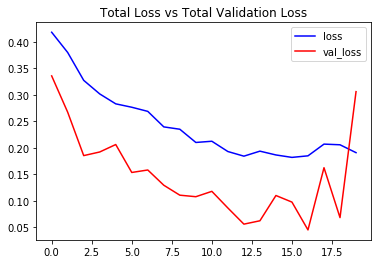

In [28]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

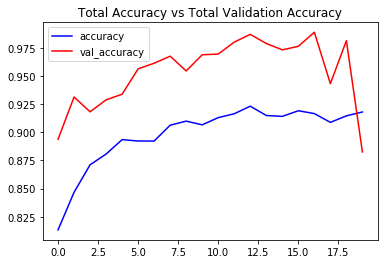

In [29]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

### Model Save and Load

In [30]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
print(model_evaluation_loss)
print(model_evaluation_accuracy)

0.30649515986442566
0.8759999871253967


In [31]:
#model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_name = 'CNN_modelBP.h5'
## Where to save
modesavedFolder = "C:/1-GG/CAP4/EventDetection/Dataset/SavedModel"

In [32]:
# Saving Model
model.save(modesavedFolder+'/'+model_name)

### How to load the model from disk

In [33]:
### How to readback the model from disk
from tensorflow import keras
model = keras.models.load_model(modesavedFolder+'/'+model_name)

In [34]:
#from sklearn.metrics import metrics
from sklearn.metrics import classification_report
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [35]:
preds=np.round(model.predict(features_test,0))

In [36]:
print('Round Test_labels' , preds)

Round Test_labels [[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [37]:
classification_metrics = classification_report(labels_test,preds, target_names = classes_list)
print(classification_metrics)

               precision    recall  f1-score   support

   Basketball       0.99      0.76      0.86       998
SoccerPenalty       0.81      0.99      0.89      1002

    micro avg       0.88      0.88      0.88      2000
    macro avg       0.90      0.88      0.87      2000
 weighted avg       0.90      0.88      0.87      2000
  samples avg       0.88      0.88      0.88      2000



### Upto Here

In [38]:
Vdo_input_directory = 'C:/1-GG/CAP4/EventDetection/Dataset/CNN_Apply_vdo/Apply_vdo'

# Getting input Video's path 
video_title = 'combined_video-2vdo'
input_video_file_path = f'{Vdo_input_directory}/{video_title}.mp4'
print(input_video_file_path)

C:/1-GG/CAP4/EventDetection/Dataset/CNN_Apply_vdo/Apply_vdo/combined_video-2vdo.mp4


In [39]:
# Setting sthe Window Size which will be used by the Rolling Average Proces
window_size = 1

Vdo_output_directory = 'C:/1-GG/CAP4/EventDetection/Dataset/CNN_Apply_vdo/OutPut_vdo'
# Setting up Output Video Path
output_video_file_path = f'{Vdo_output_directory}/{video_title} -Output-WSize {window_size}.mp4'

print(output_video_file_path)

C:/1-GG/CAP4/EventDetection/Dataset/CNN_Apply_vdo/OutPut_vdo/combined_video-2vdo -Output-WSize 1.mp4


In [40]:
video_file_path = input_video_file_path

video_reader = cv2.VideoCapture(video_file_path)

if not video_reader.isOpened():
    print("Cannot open file")
else:
    print("Open successfully")
    



Open successfully


### Define Live VDO prediction function

In [41]:
def predict_on_live_video(video_file_path, output_file_path, window_size):
    
    #print(video_file_path)

    # Initialize a Deque Object with a fixed size which will be used to implement moving/rolling average functionality.
    predicted_labels_probabilities_deque = deque(maxlen = window_size)

    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting the width and height of the video 
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Writing the Overlayed Video Files Using the VideoWriter Object
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 24, (original_video_width, original_video_height))

    while True: 

        # Reading The Frame
        status, frame = video_reader.read() 
        
        if not status:
            break

        # some frames with black - skip those
        ## images in openCV (or in your case frames) are represented as a numpy array, 
        ## they can be averaged for low values (which represent black frames).
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  ## Convert to grey image (black and white)
        if np.average(gray) < 20:  ## if it dark screen , skip 
        # skips an iteration, so the frame isn't saved
          continue
        
        
        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_deque.append(predicted_labels_probabilities)

        # Assuring that the Deque is completely filled before starting the averaging process
        if len(predicted_labels_probabilities_deque) == window_size:

            # Converting Predicted Labels Probabilities Deque into Numpy array
            predicted_labels_probabilities_np = np.array(predicted_labels_probabilities_deque)

            # Calculating Average of Predicted Labels Probabilities Column Wise 
            predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)
            avg_prob = np.array_str(predicted_labels_probabilities_averaged)
            ##print(predicted_labels_probabilities_averaged)
            # Converting the predicted probabilities into labels by returning the index of the maximum value.
            predicted_label = np.argmax(predicted_labels_probabilities_averaged)
           
            # Accessing The Class Name using predicted label.
            predicted_class_name = classes_list[predicted_label]
          
            # Overlaying Class Name Text Ontop of the Frame
            cv2.putText(frame, predicted_class_name, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            #cv2.putText(frame, avg_prob, (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
            cv2.putText(frame, 
                        avg_prob, 
                       (80, 100),   # bottomLeftCornerOfText
                       cv2.FONT_HERSHEY_SIMPLEX, 
                       1, 
                       (0, 0, 255), 
                       2)
                       
        # Writing The Frame
        video_writer.write(frame)


        # cv2.imshow('Predicted Frames', frame)

        # key_pressed = cv2.waitKey(10)

        # if key_pressed == ord('q'):
        #     break

    # cv2.destroyAllWindows()

    
    # Closing the VideoCapture and VideoWriter objects and releasing all resources held by them. 
    video_reader.release()
    video_writer.release()

In [42]:
%%time
# Calling the predict_on_live_video method to start the Prediction.
predict_on_live_video(input_video_file_path, output_video_file_path, window_size)
print("Predicted Video Created")


Predicted Video Created
Wall time: 2min 6s


In [44]:
## Feature selection from 2-vdo
#Sequential - vgg16 
#CNN - REsize
#Lstm - another way 